Max Temp: 30.18°C
Min Temp: 21.23°C


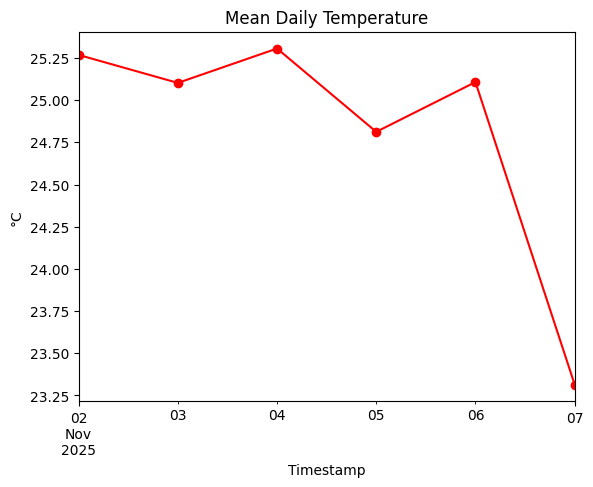

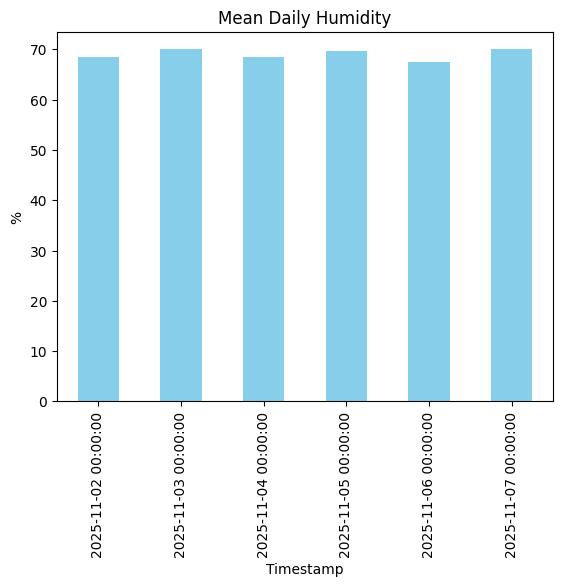

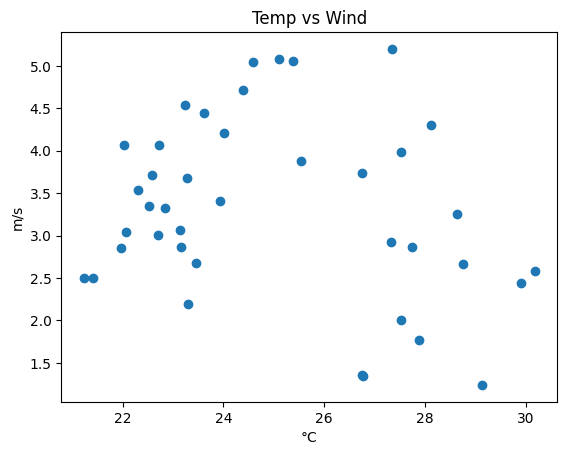

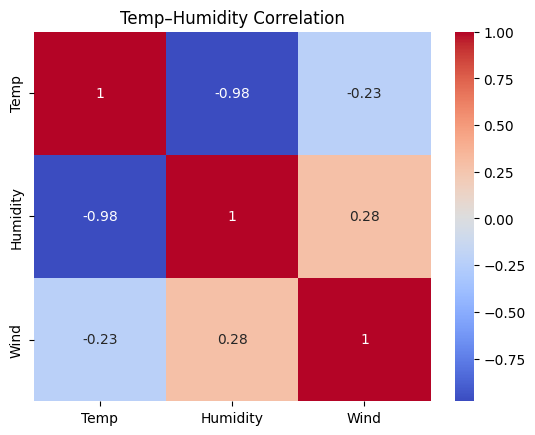

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

api_key = "e34452c3a9b23a21b38fe815fdd57b12"   # <- replace
lat, lon = 18.184135, 74.610764

def fetch_json(url):
    r = requests.get(url, timeout=10)
    try:
        j = r.json()
    except ValueError:
        print("Error: response not JSON. Status:", r.status_code)
        print("Raw text:", r.text[:400])
        return None, r
    return j, r

# 5-day forecast URL
forecast_url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}"
data, resp = fetch_json(forecast_url)

# Validate response contains forecast 'list'
if data is None:
    raise SystemExit("No JSON returned from forecast endpoint.")
if resp.status_code != 200 or 'list' not in data:
    # Print server error details for debugging
    print("Forecast request failed.")
    print("Status code:", resp.status_code)
    print("Response JSON:", data)
    # Try fallback: current weather endpoint (single data point)
    current_url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}"
    data_cur, resp_cur = fetch_json(current_url)
    if resp_cur.status_code == 200 and data_cur:
        print("Using current weather fallback.")
        items = [{
            'dt': data_cur.get('dt'),
            'main': data_cur.get('main', {}),
            'wind': data_cur.get('wind', {}),
            'weather': data_cur.get('weather', [{'description': ''}])
        }]
    else:
        print("Current weather fallback failed too. Exiting.")
        raise SystemExit
else:
    items = data['list']

# Build DataFrame (works for forecast list or single-item fallback)
rows = []
for i in items:
    # Some endpoints may lack keys; use .get with defaults
    ts = pd.to_datetime(i.get('dt'), unit='s')
    main = i.get('main', {})
    wind = i.get('wind', {})
    weather_desc = i.get('weather', [{'description': ''}])[0].get('description', '')
    temp_k = main.get('temp', None)
    # Only include rows that have a timestamp and temperature
    if ts is None or temp_k is None:
        continue
    rows.append({
        'Timestamp': ts,
        'Temp': temp_k - 273.15,   # Kelvin -> Celsius
        'Humidity': main.get('humidity', None),
        'Wind': wind.get('speed', None),
        'Desc': weather_desc
    })

if not rows:
    raise SystemExit("No usable weather rows found.")

weather = pd.DataFrame(rows).set_index('Timestamp')

# Quick stats + daily mean + plots
print(f"Max Temp: {weather['Temp'].max():.2f}°C")
print(f"Min Temp: {weather['Temp'].min():.2f}°C")

# Only aggregate numeric columns to avoid dtype issues (Desc is object)
numeric_cols = ['Temp', 'Humidity', 'Wind']
daily = weather[numeric_cols].resample('D').mean()

daily['Temp'].plot(title='Mean Daily Temperature', color='red', marker='o'); plt.ylabel('°C'); plt.show()
daily['Humidity'].plot(kind='bar', title='Mean Daily Humidity', color='skyblue'); plt.ylabel('%'); plt.show()
plt.scatter(weather['Temp'], weather['Wind']); plt.title('Temp vs Wind'); plt.xlabel('°C'); plt.ylabel('m/s'); plt.show()

# Correlation on numeric columns only
sns.heatmap(weather[numeric_cols].corr(), annot=True, cmap='coolwarm'); plt.title('Temp–Humidity Correlation'); plt.show()
